In this project I will put into practice different time series forecasting techniques. As part of my inspiration, I have taken an example from the following article which I recommend to read:
https://ai.googleblog.com/2021/12/interpretable-deep-learning-for-time.html
As a summary, first of all we are going to use CryptoWatch, a portal that provides us with an API for obtaining cryptocurrency data. We will make a code that will allow us to evaluate the profitability of all cryptocurrencies in Coinbase Pro in the last week.

However, to ensure the usefulness of this code in the long term and to take into account an interesting case for the majority of the public, we will make predictions about the Bitcoin in USD.

We will use PyCaret as the main module to compare different modelling modes such as ARIMA, and we will use the best results to make a bundle of the best 3 to have a more reliable result.

Note: Still in Progress

In [ ]:
%%capture
!pip install cryptowatch-sdk
!pip install sktime
!mkdir -p $HOME/.cw
!echo "apikey: XNS40GIEET88LR35UE2S" > $HOME/.cw/credentials.yml
!cat  $HOME/.cw/credentials.yml

In [ ]:
import cryptowatch as cw
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot
import logging
from sktime.utils.plotting import plot_series

In [ ]:
#Reduce the Verbose for cryptowatch
logging.basicConfig()
logging.getLogger("cryptowatch").setLevel(logging.WARNING)

In [ ]:
#If we would like to analyse the most profitable Cryptos of the last week:
umbral_benef = 25 #We establish a return of 25% in the last 24h.
MARKET="coinbase-pro" #We will use the marketplace of the well known Coinbase portal


coinbase = cw.markets.list(MARKET)
for market in coinbase.markets:

    try:
        ticker = "{}:{}".format(market.exchange, market.pair).upper()
        candles = cw.markets.get(ticker, ohlc=True, periods=["1w"]) 
#We set the period to 1 week ago


        close_ts, wkly_open, wkly_close = (
            candles.of_1w[-1][0],
            candles.of_1w[-1][1],
            candles.of_1w[-1][4],
        )

        if wkly_open == 0:
            continue
        perf = (wkly_open - wkly_close) * 100 / wkly_open

    
        if perf >= umbral_benef:
            open_ts = datetime.utcfromtimestamp(close_ts) - timedelta(days=7)
            print("{} changed {:.2f}% since {}".format(ticker, perf, open_ts))
    except:
        print("Execption captured, continue ..")

Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
Execption captured, continue ..
COINBASE-PRO:FIDAUSD changed 28.13% since 2022-02-10 00:00:00
COINBASE-PRO:FIDAUSDT changed 27.83% since 2022-02-10 00:00:00
Execption captured, continue ..
COINBASE-PR

In [ ]:
#We choose 1 cryptocurrency, in our case we will use the Bitcoin in dollars (USD).
TICKET="BTCUSD"
TABLE = "candles_15min_"+TICKET
candles = cw.markets.get(MARKET+":"+TICKET, ohlc=True)

In [ ]:
#We create a dataframe with the chosen Crypto
rows_list = []
#In the next line we set the information to be every 15 minutes.
for x in candles.of_15m:
    close_ts = datetime.utcfromtimestamp(x[0])
    open_value = x[1]
    high_value = x[2]
    low_value = x[3]
    close_value = x[4]
    volume_base = x[5]
    volume_quote = x[6]
    rows_list.append([TICKET,close_ts , open_value , high_value , low_value ,close_value ,volume_base ,volume_quote])
df = pd.DataFrame(rows_list,columns = ["ticket","close_ts" , "open_value" , "high_value" , "low_value" ,"close_value" ,"volume_base" ,"volume_quote" ])
df.head()

,ticket,close_ts,open_value,high_value,low_value,close_value,volume_base,volume_quote
0,BTCUSD,2022-02-06 11:30:00,41553.86,41571.98,41534.52,41561.32,12.974134,5.391251e+05
1,BTCUSD,2022-02-06 11:45:00,41561.32,41593.07,41519.28,41519.29,25.787295,1.071675e+06
2,BTCUSD,2022-02-06 12:00:00,41519.29,41553.47,41456.21,41538.60,42.940821,1.782031e+06
3,BTCUSD,2022-02-06 12:15:00,41536.85,41664.02,41536.85,41640.68,39.920450,1.661175e+06
4,BTCUSD,2022-02-06 12:30:00,41640.69,41665.51,41596.63,41608.93,29.149472,1.213502e+06


# We are going to use the pyCaret Framework, which allows us to compare between the best regression models.

In [ ]:
!pip install pycaret-ts-alpha &> /dev/null
!pip install pyyaml
from pycaret.datasets import get_data
from pycaret.time_series import *
!pip install --upgrade pandas
import pandas as pd
import numpy as np

In [ ]:
from pandas.core.indexes.datetimes import date_range
index = pd.DatetimeIndex(df["close_ts"])
rng = date_range(index[0], periods = 1000, freq="15min")
data = df["close_value"].to_numpy()
#PyCaret works with pandas series instead of Dataframes, so we have to transform it.
df_series = pd.Series(data=data, index=rng)

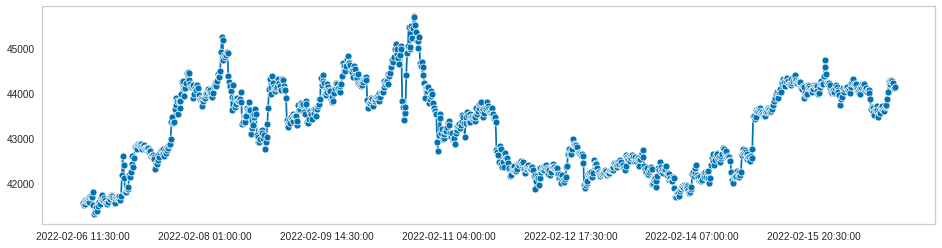

In [ ]:
!pip install matplotlib &> /dev/null
!pip install scipy
import matplotlib.pyplot as plt
_ = plot_series(df_series)
plt.grid()

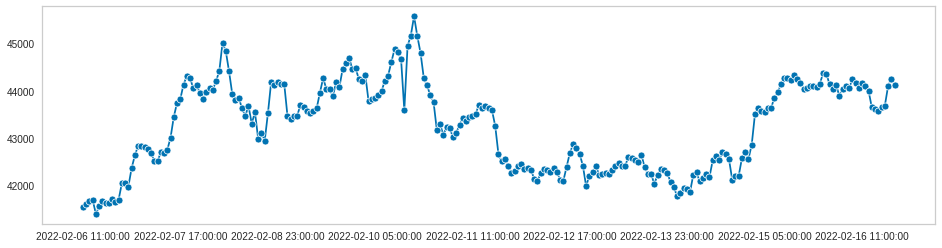

In [ ]:
#For better performance, we resample the data to take the mean for each hour, taking 4 samples of 15 minutes
df_series_t = df_series.resample("H").mean()
_ = plot_series(df_series_t)
plt.grid()

In [ ]:
exp = TimeSeriesExperiment()
#fh is set in hours so we introduce 48h
exp.setup(data=df_series_t, fh=48, use_gpu = True)

,Description,Value
0,session_id,1134
1,Original Data,"(251, 1)"
2,Missing Values,False
3,Transformed Train Set,"(203,)"
4,Transformed Test Set,"(48,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,24
9,Seasonality Detected,False


INFO:logs:self.master_model_container: 0
INFO:logs:self.display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      float_dtype='float64', id_columns=[],
                                      ml_usecase='regression',
                                      numerical_features=[],
                                      target='Time Series', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical='not_available',
                                fill_v...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummif

In [ ]:
best_baseline_models = exp.compare_models(n_select=4, sort="MAE")

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
naive,Naive Forecaster,629.1379,718.8179,0.0147,0.0145,3.1845,2.5661,-1.8907,0.0400
auto_arima,Auto ARIMA,629.1379,718.8179,0.0147,0.0145,3.1845,2.5661,-1.8907,0.8367
theta,Theta Forecaster,638.6033,764.132,0.0149,0.0147,3.2503,2.7577,-2.0026,0.0467
arima,ARIMA,711.112,835.7394,0.0165,0.0164,3.699,3.1053,-3.692,0.0667
croston,Croston,847.5418,948.1826,0.0197,0.0195,4.2924,3.3983,-3.86,0.0267
snaive,Seasonal Naive Forecaster,871.1051,999.8335,0.0202,0.02,4.4293,3.6151,-4.1369,0.0200
ets,ETS,894.4402,1012.9483,0.0209,0.0205,4.5244,3.5934,-5.2131,0.0600
grand_means,Grand Means Forecaster,979.7009,1073.0142,0.0227,0.0227,5.1523,4.0132,-9.4714,0.0233
exp_smooth,Exponential Smoothing,1107.7815,1228.5519,0.0257,0.0252,5.6533,4.4554,-6.7181,0.0367
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1440.3953,1567.7496,0.0335,0.0326,7.3213,5.6677,-11.4906,0.3033


INFO:logs:master_model_container: 27
INFO:logs:display_container: 2
INFO:logs:[NaiveForecaster(sp=1, strategy='last', window_length=None), AutoARIMA(D=None, alpha=0.05, d=None, error_action='warn',
          information_criterion='aic', max_D=1, max_P=2, max_Q=2, max_d=2,
          max_order=5, max_p=5, max_q=5, maxiter=50, method='lbfgs', n_fits=10,
          n_jobs=1, offset_test_args=None, out_of_sample_size=0, random=False,
          random_state=1134, scoring='mse', scoring_args=None, seasonal=True,
          seasonal_test='ocsb', seasonal_test_args=None, sp=1, start_P=1,
          start_Q=1, start_p=2, start_params=None, ...), ThetaForecaster(deseasonalize=True, initial_level=None, sp=24), ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)]
INFO:logs:compare_models() successfully completed..............

In [ ]:
#Here we have the 4 best models, but they are not tuned yet tho have their best performance
best_baseline_models

[NaiveForecaster(sp=1, strategy='last', window_length=None),
 AutoARIMA(D=None, alpha=0.05, d=None, error_action='warn',
           information_criterion='aic', max_D=1, max_P=2, max_Q=2, max_d=2,
           max_order=5, max_p=5, max_q=5, maxiter=50, method='lbfgs', n_fits=10,
           n_jobs=1, offset_test_args=None, out_of_sample_size=0, random=False,
           random_state=1134, scoring='mse', scoring_args=None, seasonal=True,
           seasonal_test='ocsb', seasonal_test_args=None, sp=1, start_P=1,
           start_Q=1, start_p=2, start_params=None, ...),
 ThetaForecaster(deseasonalize=True, initial_level=None, sp=24),
 ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
       scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
       start_params=None, suppress_warnings=False, trend=None,
       with_intercept=True)]

In [ ]:
#Here we call this line to make an Hyperparameterm Tuning of the 4 better models
best_tuned_models = [exp.tune_model(model) for model in best_baseline_models]

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-02-08 21:00,626.2553,819.0827,0.0141,0.0142,3.3134,3.2749,-1.6616
1,2022-02-10 21:00,765.6856,859.6541,0.0180,0.0178,3.7679,2.9054,-1.4216
2,2022-02-12 21:00,339.5883,404.2364,0.0081,0.0080,1.8571,1.5174,-2.1351
Mean,NaT,577.1764,694.3244,0.0134,0.0133,2.9795,2.5659,-1.7394
SD,NaT,177.3815,205.7908,0.0041,0.0040,0.8151,0.7566,0.2964


INFO:logs:master_model_container: 38
INFO:logs:display_container: 6
INFO:logs:ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 1, 24),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
best_baseline_models

[NaiveForecaster(sp=1, strategy='last', window_length=None),
 AutoARIMA(D=None, alpha=0.05, d=None, error_action='warn',
           information_criterion='aic', max_D=1, max_P=2, max_Q=2, max_d=2,
           max_order=5, max_p=5, max_q=5, maxiter=50, method='lbfgs', n_fits=10,
           n_jobs=1, offset_test_args=None, out_of_sample_size=0, random=False,
           random_state=1134, scoring='mse', scoring_args=None, seasonal=True,
           seasonal_test='ocsb', seasonal_test_args=None, sp=1, start_P=1,
           start_Q=1, start_p=2, start_params=None, ...),
 ThetaForecaster(deseasonalize=True, initial_level=None, sp=24),
 ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
       scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
       start_params=None, suppress_warnings=False, trend=None,
       with_intercept=True)]

In [ ]:
#This line focus all the efforts, blending the 4 best models already tuned with the mean of the 4
mean_blender = exp.blend_models(best_tuned_models, method="mean")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-02-08 21:00,402.8683,499.3538,0.0091,0.0091,2.1315,1.9965,0.0107
1,2022-02-10 21:00,1110.0301,1239.3342,0.0261,0.0257,5.4625,4.1886,-4.0330
2,2022-02-12 21:00,210.9768,257.0020,0.0050,0.0050,1.1537,0.9647,-0.2672
Mean,NaT,574.6251,665.2300,0.0134,0.0133,2.9159,2.3833,-1.4298
SD,NaT,386.6088,417.8359,0.0091,0.0089,1.8444,1.3442,1.8442


INFO:logs:master_model_container: 39
INFO:logs:display_container: 7
INFO:logs:_EnsembleForecasterWithVoting(forecasters=[('Naive Forecaster',
                                            NaiveForecaster(sp=1,
                                                            strategy='last',
                                                            window_length=None)),
                                           ('Auto ARIMA',
                                            AutoARIMA(D=None, alpha=0.05,
                                                      d=None,
                                                      error_action='warn',
                                                      information_criterion='aic',
                                                      max_D=1, max_P=2, max_Q=2,
                                                      max_d=2, max_order=5,
                                                      max_p=5, max_q=5,
                                                    

INFO:logs:Initializing get_config()
INFO:logs:get_config(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x7f010d617a10>, variable=y_train)
INFO:logs:Variable: y_train returned as 2022-02-06 11:00    41540.3050
2022-02-06 12:00    41599.0900
2022-02-06 13:00    41663.6675
2022-02-06 14:00    41687.0225
2022-02-06 15:00    41387.7525
                       ...    
2022-02-14 17:00    42662.2850
2022-02-14 18:00    42550.1750
2022-02-14 19:00    42116.1575
2022-02-14 20:00    42181.4325
2022-02-14 21:00    42197.6325
Freq: H, Name: Time Series, Length: 203, dtype: float64
INFO:logs:get_config() succesfully completed......................................
INFO:logs:Preparing display monitor


,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,EnsembleForecaster,1714.6158,1768.4312,0.039,0.0398,10.2223,7.211,-15.1061


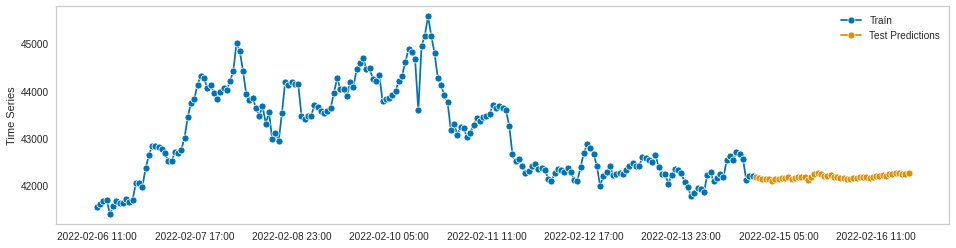

In [ ]:
y_train = exp.get_config("y_train")
y_predict = exp.predict_model(mean_blender)

plot_series( y_train, y_predict, labels=[ "Traín", "Test Predictions"])
plt.grid()